In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

import os
os.chdir("..")

# Import relevant packages
from src.eda import data_info
from src.explainability import *

# Import necessary libraries
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import wilcoxon
import numpy as np
from itertools import combinations
from scipy.stats import skew
from statsmodels.stats.descriptivestats import sign_test

# Set plotting parameters
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'
plt.rcParams['font.size'] = 9

In [2]:
# Chosen tuning objective
metric = "AUC"
x_size = 12000
explain_size = 500

"""for script in ["explain", "explain_eval"]:

    # Create the script directory if it doesn't exist
    os.makedirs("scripts", exist_ok=True)
    with open(f"scripts/{script}.sh", "w") as f:
        f.write("#!/bin/bash\n")

    # Create .sh file:
    for model_type in ["baseline", "dpsgd"]:
        if model_type == "baseline":
            n_line = x_size // explain_size + 1
        else:
            n_line = (x_size // explain_size + 1) * 3

        for i in range(n_line): 
            txt = f'python3.11 "scripts/{script}.py" --metric {metric}'
            if i > 0:
                txt += f' --continue_run True'
            if model_type == "dpsgd":
                txt += f' --model_type {model_type}'
            with open(f"scripts/{script}.sh", "a") as f:
                f.write(txt + "\n")"""

'for script in ["explain", "explain_eval"]:\n\n    # Create the script directory if it doesn\'t exist\n    os.makedirs("scripts", exist_ok=True)\n    with open(f"scripts/{script}.sh", "w") as f:\n        f.write("#!/bin/bash\n")\n\n    # Create .sh file:\n    for model_type in ["baseline", "dpsgd"]:\n        if model_type == "baseline":\n            n_line = x_size // explain_size + 1\n        else:\n            n_line = (x_size // explain_size + 1) * 3\n\n        for i in range(n_line): \n            txt = f\'python3.11 "scripts/{script}.py" --metric {metric}\'\n            if i > 0:\n                txt += f\' --continue_run True\'\n            if model_type == "dpsgd":\n                txt += f\' --model_type {model_type}\'\n            with open(f"scripts/{script}.sh", "a") as f:\n                f.write(txt + "\n")'

In [3]:
shap_dict = {}

for model_type in ["baseline", "dpsgd"]:
    # Initialize the SHAP explainer
    shap_init = ShapKernelExplainer(model_type=model_type, metric=metric)
    # Get the model version and predictions
    for i, row in shap_init.model_info.sort_values("version", ascending=True).iterrows():
        version = row["version"]
        try:
            explanation = pd.read_feather(f"results/explainability/{model_type}/{version}_fixed.feather").values
        except FileNotFoundError:
            explanation = []
        if model_type == "baseline":
            eps = None
        else:
            eps = row['epsilon']
        shap_dict[(model_type, version, eps)] = explanation

X_test = shap_init.X_test.values
all_cols = shap_init.all_cols

## 1. Visualize the SHAP values

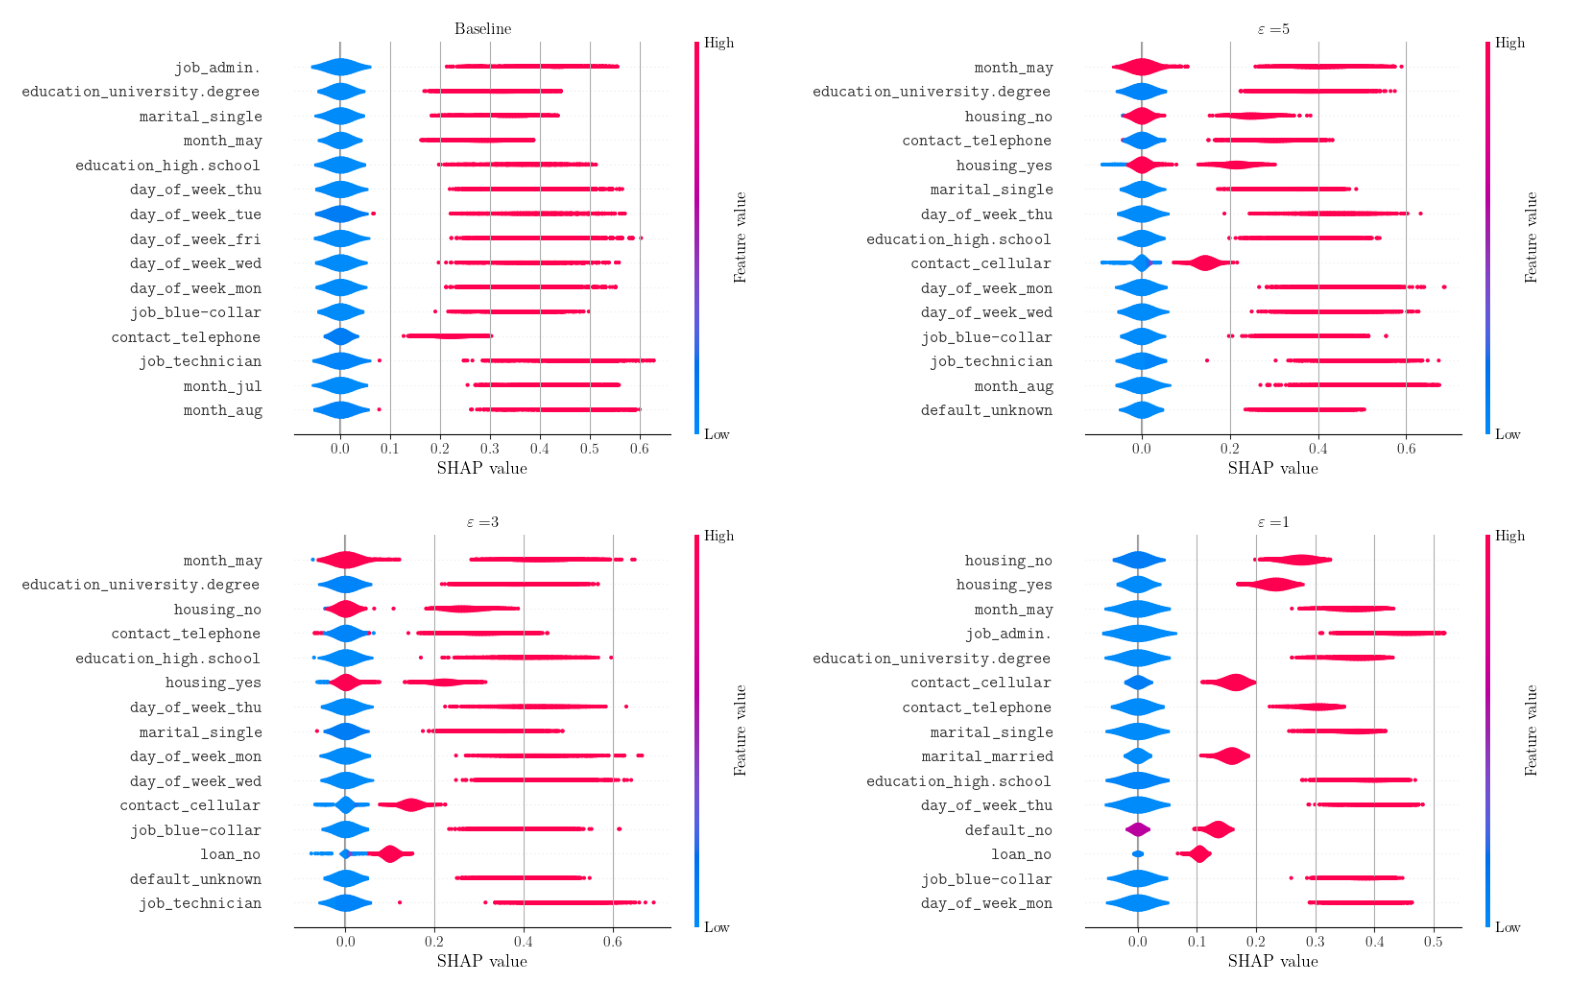

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows x 2 cols
# Flatten the axes array for easier indexing
axes = axes.flatten()
j = 0

for (model_type, version, eps), explanation in shap_dict.items():
    # Get the model predictions
    y_pred = pd.read_feather(f"experiments/predictions/{model_type}/{version}_pred.feather")
    # Get the input of anomalies
    #x_anomaly = shap_init.X_test[y_pred['anomaly']==1].values
    # Get the SHAP values
    if explanation == []:
        continue
    else:
        shap_values = normalize_shap(explanation, method="l2")
    # Plot the SHAP values
    if model_type == "baseline":
        title = "Baseline"
    else:
        title = r"$\varepsilon =$" + f"{eps:.0f}"
    # Create a temporary figure
    temp_fig = plt.figure()
    shap.summary_plot(shap_values,
                features=X_test,
                feature_names=[f"\\texttt{{{col}}}" for col in all_cols],
                show=False,
                plot_size=(8, 5),
                max_display=15,
                plot_type="violin",
                title=title,
                )
    #plt.xlim(-0.2, 1.25)  # Set x-axis limits to -0.5 and 1
    # Draw the canvas, copy contents, and close temp
    temp_fig.canvas.draw()
    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(temp_fig)

    # Show the image in the target subplot
    axes[j].imshow(image)
    axes[j].axis("off")
    j += 1

plt.tight_layout()
plt.savefig(f"results/figures/shap_values.png", bbox_inches='tight', dpi=300)
plt.show()

In [5]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap = {}
for (model_type, version, eps), explanation in shap_dict.items():
    if explanation == []:
        continue
    else:
        shap_values = normalize_shap(explanation, method="l2")
    mean_abs_shap[(model_type, version, eps)] = pd.DataFrame(np.sum(np.abs(shap_values), axis=0), index=all_cols).reset_index(names="feature").sort_values(by=0, ascending=False, ignore_index=True).reset_index(names="rank")[["rank", "feature"]].set_index("feature")
shap_df = pd.concat(mean_abs_shap.values(), axis=1)
shap_df.columns = ["baseline", "dpsgd_5", "dpsgd_3", "dpsgd_1"]
(shap_df + 1).to_csv(f"results/explainability/feature_ranking.csv")

## 2. Infidelity, Sensitivity, and AOPC

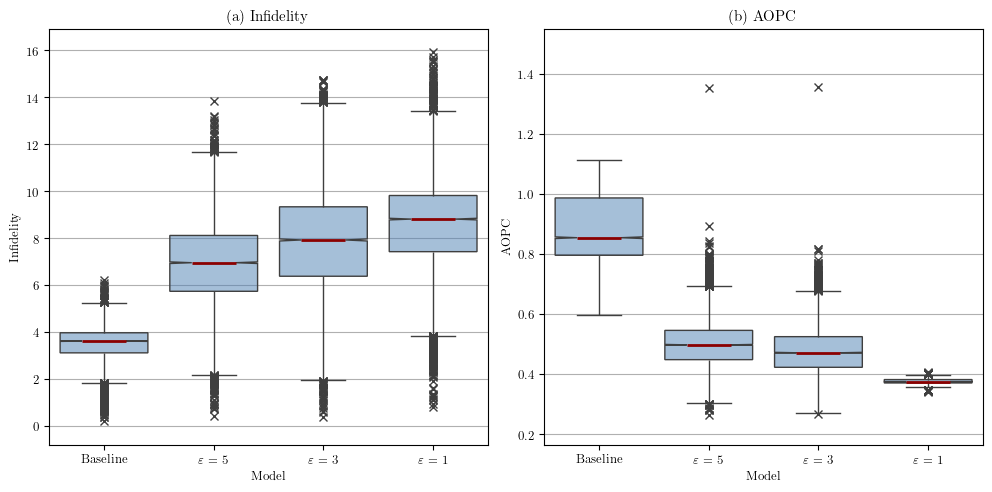

In [6]:
# Create figure and define the grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# First plot: Infidelity
ax1 = axes[0]

# Second plot: Sensitivity
ax2 = axes[1]

df = pd.DataFrame(columns=["model", "infidelity", "aopc"])
# Plot the metrics for the baseline and DPSGD models
for (model_type, version, eps), explanation in shap_dict.items():
    try:
        # Get the explainability metrics
        perf_metrics = pd.read_feather(f"results/explainability/{model_type}/{version}_fixed_eval.feather")
        perf_metrics["model"] = model_type.capitalize() if model_type == "baseline" else r"$\varepsilon$" + f" = {eps:.0f}"

        # Append the metrics to the DataFrame
        df = pd.concat([df, perf_metrics], ignore_index=True)
    except FileNotFoundError:
        print(f"File not found for {model_type} with version {version}")

df.fillna(0, inplace=True)

sns.boxplot(data=df,
            x="model",
            y="infidelity",
            ax=ax1,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "darkred", "linewidth": 2},
            notch=True, showcaps=True)

sns.boxplot(data=df,
            x="model",
            y="aopc",
            ax=ax2,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "darkred", "linewidth": 2},
            notch=True, showcaps=True)

# Set the titles for the subplots
ax1.set_title("(a) Infidelity")
ax2.set_title("(b) AOPC")

# Set the y-axis labels
ax1.set_ylabel("Infidelity")
ax2.set_ylabel("AOPC")

# Set the y-axis labels
for ax in [ax1, ax2]:
    ax.set_xlabel("Model")
    ax.grid(axis='y')

# Set y-axis limits
iqr_range1 = df["infidelity"].quantile(0.75) - df["infidelity"].quantile(0.25)
iqr_range2 = df["aopc"].quantile(0.75) - df["aopc"].quantile(0.25)
ax1.set_ylim(max(df["infidelity"].quantile(0.25) - 3 * iqr_range1, df["infidelity"].min() - 1), min(df["infidelity"].quantile(0.75) + 3 * iqr_range1, df["infidelity"].max() + 1))
ax2.set_ylim(max(df["aopc"].quantile(0.25) - 3 * iqr_range2, df["aopc"].min() - 0.1), min(df["aopc"].quantile(0.75) + 3 * iqr_range2, df["aopc"].max() + 0.1))

plt.tight_layout()
plt.savefig(f"results/figures/shap_metrics.png", bbox_inches='tight', dpi=300)
plt.show()

In [7]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
def iqr(x):
    return q3(x) - q1(x)
summary_table = df.melt(id_vars=["model"], value_vars=["infidelity", "aopc"], var_name="metric", value_name="value").groupby(["metric", "model"]).agg(["mean", "std", "median", "min", "max", q1, q3, iqr]).reset_index()
summary_table["outlier_threshold"] = summary_table["value"]["q3"] + 1.5 * summary_table["value"]["iqr"]
summary_table

metric              model     value                                \
                                      mean       std    median       min   
0        aopc  $\varepsilon$ = 1  0.378415  0.101914  0.374940  0.340336   
1        aopc  $\varepsilon$ = 3  0.476203  0.075787  0.471055  0.268006   
2        aopc  $\varepsilon$ = 5  0.499196  0.075864  0.497390  0.265556   
3        aopc           Baseline  0.880927  0.147785  0.853861  0.595028   
4  infidelity  $\varepsilon$ = 1  8.579021  1.940279  8.813175  0.831483   
5  infidelity  $\varepsilon$ = 3  7.811470  2.208965  7.924577  0.394639   
6  infidelity  $\varepsilon$ = 5  6.903650  1.826721  6.956479  0.446100   
7  infidelity           Baseline  3.455213  0.778512  3.618032  0.212627   

                                           outlier_threshold  
         max        q1        q3       iqr                    
0   8.059310  0.370607  0.381864  0.011257          0.398751  
1   1.663726  0.422697  0.524620  0.101922          0.677503  
2   1.684761  0.448122  0.545526  0.097404          0.691633  
3   8.059048  0.795404  0.986124  0.190721          1.272205  
4  15.925934  7.426064  9.817329  2.391265         13.404227  
5  14.746138  6.380043  9.336307  2.956264         13.770704  
6  13.825346  5.739257  8.116298  2.377041         11.681859  
7   6.214384  3.118184  3.973105  0.854921          5.255486

In [8]:
def run_pairwise_wilcoxon(df, metric_col='aopc'):
    # List all model names
    models = df.model.unique()

    pivot_df = pd.DataFrame()
    
    for model in models:
        model_df = df[df['model'] == model][[metric_col]].reset_index(drop=True).rename(columns={metric_col: f"{model}"})
        pivot_df = pd.concat([pivot_df, model_df], axis=1)

    table = pd.DataFrame(index=models, columns=models)

    for m1, m2 in combinations(models, 2):
        diffs = pivot_df[m1] - pivot_df[m2]
        skewness_value = skew(diffs)
        print(f"Skewness: {skewness_value:.3f}")
        #stat, p = wilcoxon(pivot_df[m1], pivot_df[m2])
        stat, p = sign_test(diffs)
        table.loc[m1, m2] = f"{stat:.3g} ({p:.3f})"
        # Fill symmetric entries
        stat, p = sign_test(-diffs)
        table.loc[m2, m1] = f"{stat:.3g} ({p:.3f})"

    # Fill diagonal with dashes or 1.000
    for m in models:
        table.loc[m, m] = "—"

    return table

display(run_pairwise_wilcoxon(df, metric_col='aopc'))
display(run_pairwise_wilcoxon(df, metric_col='infidelity'))

Skewness: 12.929
Skewness: 11.473
Skewness: 0.074
Skewness: -1.164
Skewness: -33.438
Skewness: -33.046


,Baseline,$\varepsilon$ = 5,$\varepsilon$ = 3,$\varepsilon$ = 1
Baseline,—,5.72e+03 (0.000),5.72e+03 (0.000),5.73e+03 (0.000)
$\varepsilon$ = 5,-5.72e+03 (0.000),—,3.83e+03 (0.000),5.21e+03 (0.000)
$\varepsilon$ = 3,-5.72e+03 (0.000),-3.83e+03 (0.000),—,4.74e+03 (0.000)
$\varepsilon$ = 1,-5.73e+03 (0.000),-5.21e+03 (0.000),-4.74e+03 (0.000),—


Skewness: -0.267
Skewness: -0.200
Skewness: 0.047
Skewness: -1.105
Skewness: 0.166
Skewness: -0.034


,Baseline,$\varepsilon$ = 5,$\varepsilon$ = 3,$\varepsilon$ = 1
Baseline,—,-5.62e+03 (0.000),-5.65e+03 (0.000),-5.68e+03 (0.000)
$\varepsilon$ = 5,5.62e+03 (0.000),—,-3.82e+03 (0.000),-3.94e+03 (0.000)
$\varepsilon$ = 3,5.65e+03 (0.000),3.82e+03 (0.000),—,-1.37e+03 (0.000)
$\varepsilon$ = 1,5.68e+03 (0.000),3.94e+03 (0.000),1.37e+03 (0.000),—


## 3. SHAPGap

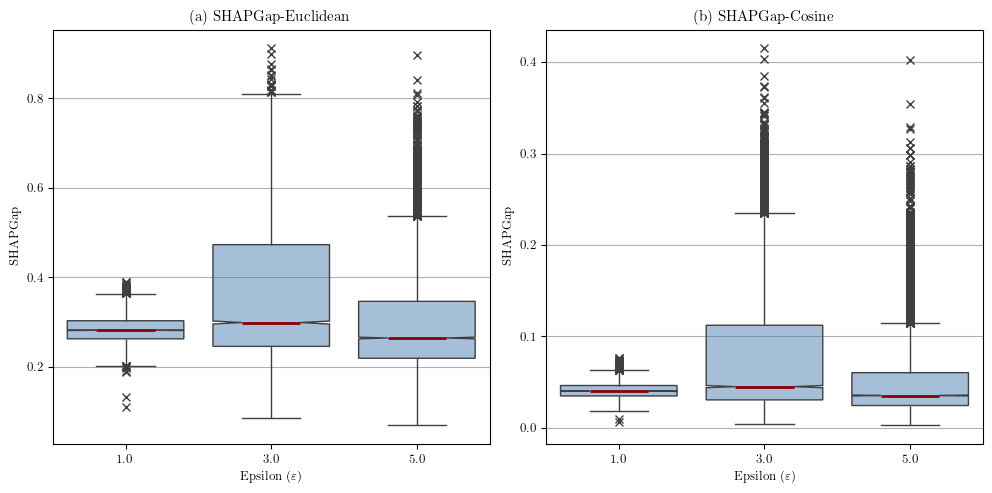

In [9]:
# Plot the SHAP values for the baseline and DPSGD models
records = []

for (model_type, version, eps), explanation in shap_dict.items():
    if model_type == "baseline":
        baseline_explanation = explanation

for (model_type, version, eps), explanation in shap_dict.items():
    if model_type == "dpsgd":
        dpsgd_explanation = explanation
        for gap_type in ["euclidean", "cosine"]:
            try:
                baseline_explanation_norm = normalize_shap(baseline_explanation, method="l2")
                dpsgd_explanation_norm = normalize_shap(dpsgd_explanation, method="l2")
                gap = shap_gap(baseline_explanation_norm, dpsgd_explanation_norm, gap_type=gap_type)
            except Exception as e:
                print(f"Error computing SHAPGap-{gap_type} for {model_type} with epsilon {eps}: {e}")
                continue
            records.append({
                "epsilon": eps,
                "gap_type": gap_type,
                "shap_gap": gap
            })

# Convert to DataFrame for seaborn
df = pd.DataFrame(records)

# Explode the 'shap_gap' column so that each list item becomes a row
df_melted = df.explode("shap_gap").reset_index(drop=True)

# Convert shapgap values to float (they may be stored as objects/strings)
df_melted["shap_gap"] = df_melted["shap_gap"].astype(float)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot each gap type
for i, gap_type in enumerate(["euclidean", "cosine"]):
    sns.boxplot(data=df_melted[df_melted["gap_type"] == gap_type], x="epsilon", y="shap_gap", ax=axes[i],
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.3, .5, .7, .5)},
                medianprops={"color": "darkred", "linewidth": 2},
                notch=True, showcaps=True)
    axes[i].set_title(f"({chr(97 + i)}) SHAPGap-{gap_type.capitalize()}")
    axes[i].set_xlabel(r"Epsilon ($\varepsilon$)")
    axes[i].set_ylabel("SHAPGap")
    axes[i].grid(axis='y')

plt.tight_layout()
plt.savefig(f"results/figures/shap_gap.png", bbox_inches='tight', dpi=300)
plt.show()

In [10]:
from scipy.stats import kurtosis
df_melted.groupby(["gap_type", "epsilon"]).agg(["mean", "std", "median", "min", "max", q1, q3, iqr, skew, kurtosis])

shap_gap                                                    \
                       mean       std    median       min       max        q1   
gap_type  epsilon                                                               
cosine    1.0      0.040828  0.008375  0.039827  0.006172  0.076144  0.034640   
          3.0      0.072768  0.060119  0.044857  0.003728  0.415061  0.030343   
          5.0      0.054513  0.048659  0.035125  0.002461  0.402284  0.024165   
euclidean 1.0      0.284277  0.029021  0.282230  0.111103  0.390240  0.263210   
          3.0      0.353901  0.142447  0.299523  0.086345  0.911110  0.246345   
          5.0      0.305455  0.125401  0.265046  0.070154  0.896977  0.219843   

                                                           
                         q3       iqr      skew  kurtosis  
gap_type  epsilon                                          
cosine    1.0      0.046065  0.011426  0.536522  0.156026  
          3.0      0.112013  0.081670  1.466173  1.944282  
          5.0      0.060129  0.035963  1.858965  3.276674  
euclidean 1.0      0.303531  0.040321  0.248394  0.013093  
          3.0      0.473314  0.226970  0.865764 -0.179482  
          5.0      0.346782  0.126939  1.214180  0.735573

In [11]:
# List all model names
gap_types = df_melted["gap_type"].unique()

for gap_type in gap_types:
    gap_df = df_melted[df_melted["gap_type"] == gap_type]
    models = gap_df["epsilon"].unique()
    table = pd.DataFrame(index=models, columns=models)
    for m1, m2 in combinations(models, 2):
        series1 = gap_df[gap_df["epsilon"] == m1]["shap_gap"]
        series2 = gap_df[gap_df["epsilon"] == m2]["shap_gap"]
        diffs = series1.values - series2.values
        skewness_value = skew(diffs)
        # Perform Wilcoxon signed-rank test
        #stat, p = wilcoxon(series1, series2)
        stat, p = sign_test(diffs)
        table.loc[m1, m2] = f"{stat:.3g} ({p:.3f})"
        # Fill symmetric entries
        stat, p = sign_test(-diffs)
        table.loc[m2, m1] = f"{stat:.3g} ({p:.3f})"
    # Fill diagonal with dashes or 1.000
    for m in models:
        table.loc[m, m] = "—"

table

,5.0,3.0,1.0
5.0,—,-4.47e+03 (0.000),-928 (0.000)
3.0,4.47e+03 (0.000),—,774 (0.000)
1.0,928 (0.000),-774 (0.000),—


## 4. Spearman’s rank correlation

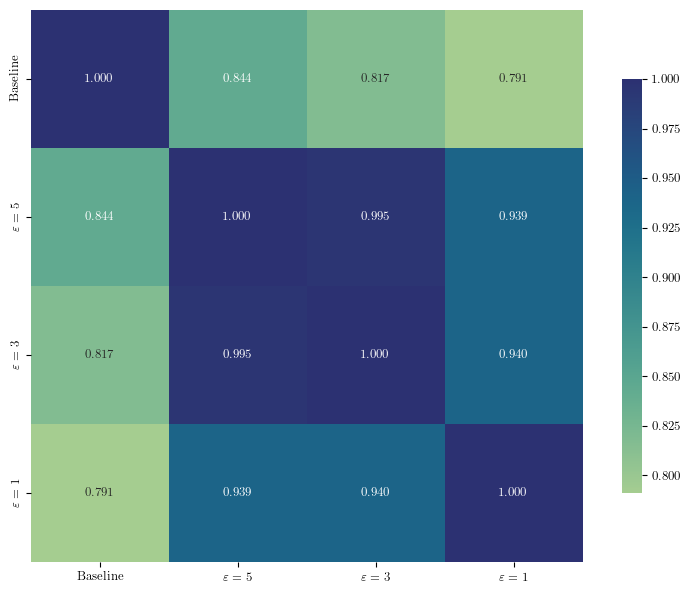

In [12]:
from itertools import permutations
from scipy.stats import spearmanr

# Assume shap_dict is already defined
label_dict = {(model_type, version, eps): r"$\varepsilon=" + f"{eps:.0f}" + r"$" if eps is not None else f"{model_type.capitalize()}" for (model_type, version, eps) in shap_dict.keys()}
labels = list(label_dict.values())

# Initialize numeric correlation table with NaNs
table = pd.DataFrame(np.nan, index=labels, columns=labels)

# Compute Spearman correlations
for m1, m2 in combinations(shap_dict.keys(), 2):
    rho, pval = spearmanr(shap_dict[m1].mean(axis=0), shap_dict[m2].mean(axis=0), alternative="greater")
    if pval >= 0.05:
        print(f"Warning: p-value {pval:.3f} for models {m1} and {m2} is not significant.")
    label1 = label_dict[m1]
    label2 = label_dict[m2]
    table.loc[label1, label2] = rho
    table.loc[label2, label1] = rho

# Fill diagonal with 1.0
np.fill_diagonal(table.values, 1.0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    table.astype(float),   # Ensure data type is float
    annot=True,
    fmt=".3f",
    cmap="crest",
    square=True,
    cbar_kws={"shrink": 0.75}
)
plt.tight_layout()
plt.savefig(f"results/figures/shap_correlation.png", bbox_inches='tight', dpi=300)
plt.show()